In [1]:
import os 
import numpy as np

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

In [2]:
# 하이퍼 파라미터  

lr = 1e-3
batch_size = 4
num_epoch = 100

data_dir = '/Users/minyoungxi/DataScience/ai/CNN/U-net/datasets' # 데이터가 저장되어 있는 디렉토리
ckpt_dir = './checkpoint' # train 된 네트워크가 저장될 디렉토리
log_dir = './log' # 텐서보드 로그파일이 저장될 디렉토리

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [3]:
print(data_dir)

/Users/minyoungxi/DataScience/ai/CNN/U-net/datasets


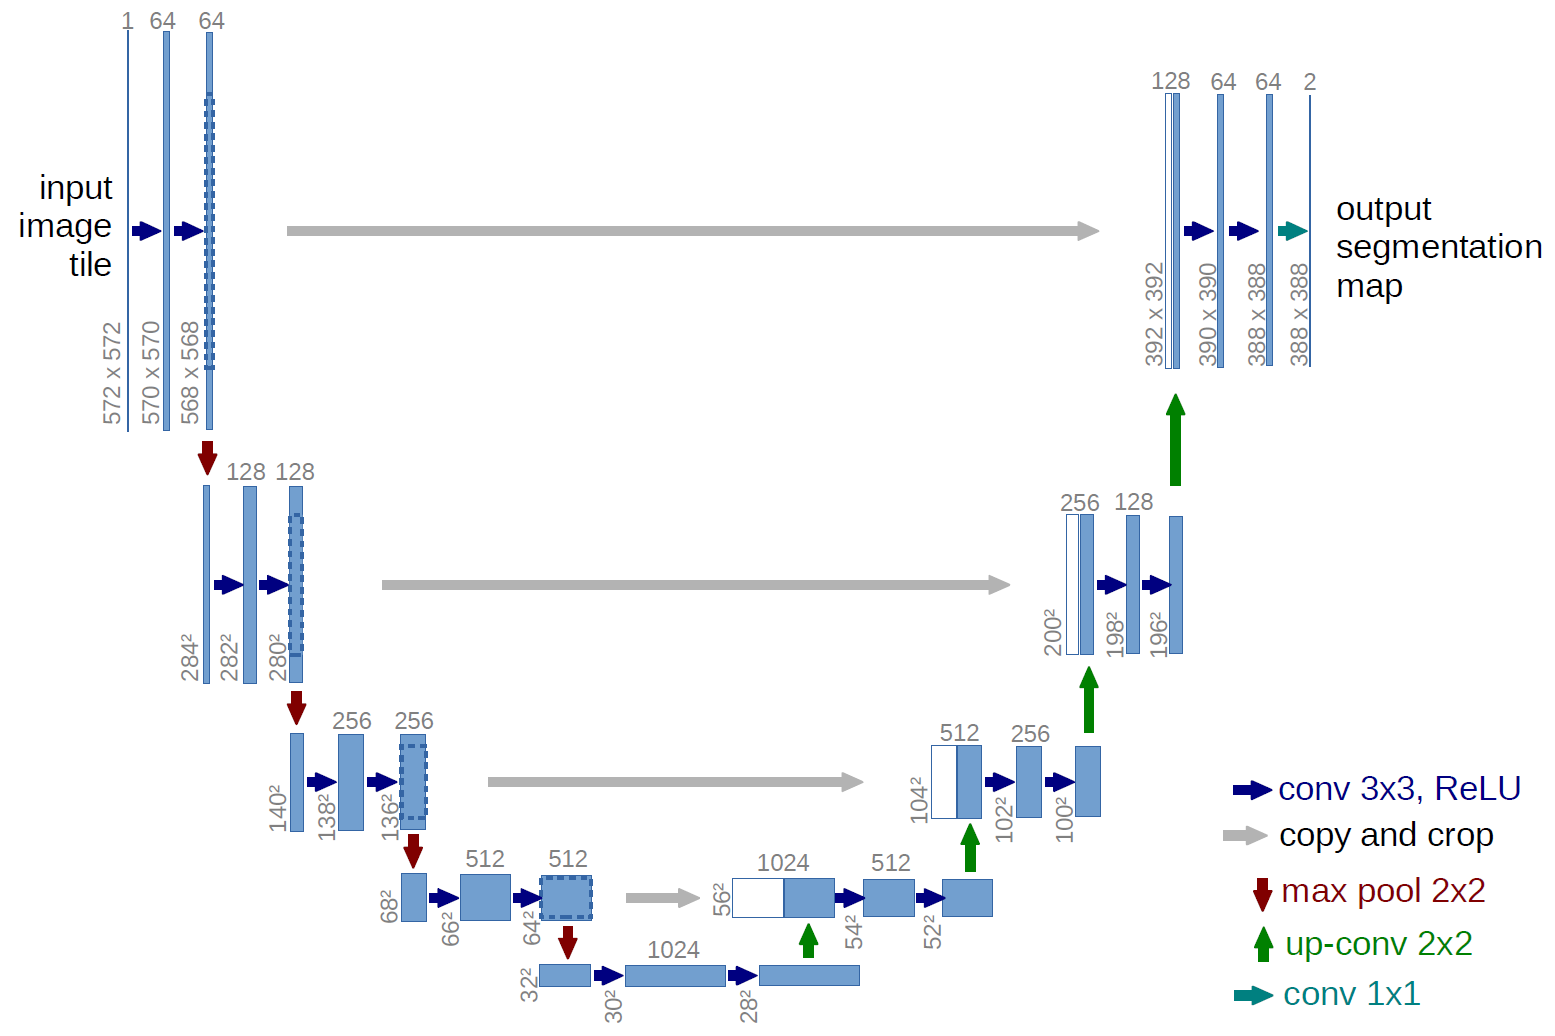

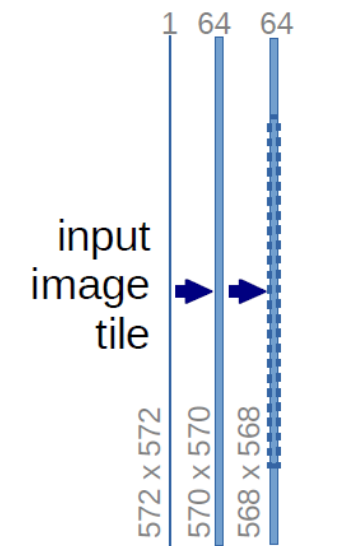

In [13]:
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0
        input = input/255.0

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

In [21]:
## 

dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))

In [22]:
data = dataset_train.__getitem__(0)

input =  data['input']
label = data['label']

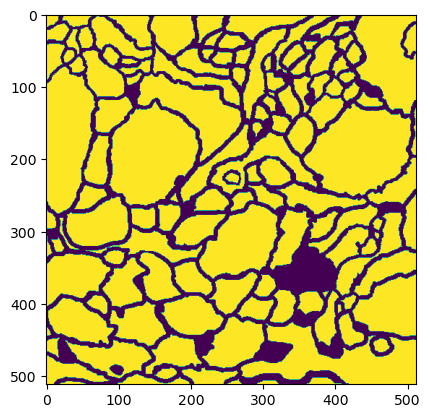

In [23]:
import matplotlib.pyplot as plt

plt.imshow(input)

##### pytorch에 들어가는 입력은 무조건 x,y,channel 디멘전 3개가 필요하다. 
##### channel이 1이라도 명시적으로 채널 디멘전을 생성해야함. 

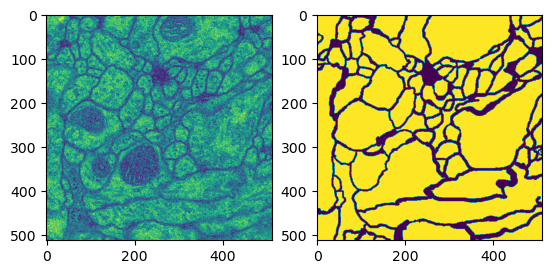

In [25]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(input.squeeze())
 
plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()

## 트랜스폼 구현 

##### 이미지의 numpy 차원 = (Y,X,CH)
##### 이미지의 tensor 차원 = (CH,Y,X)

In [28]:
## Transform 

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        label = label.transpose((2, 0, 1)).astype(np.float32) # numpy -> tensor로 구조 변경
        input = input.transpose((2, 0, 1)).astype(np.float32)
        
        data = {'label' : torch.from_numpy(label), 'input': torch.from_numpy(input)}
        
        return data
    
class Normalization(object):
    def __init__(self, mean=0.5 , std=0.5):
        self.mean = mean
        self.std = std
        
    def __call__(self, data):
        label, input = data['label'] , data['input']
        
        input = (input - self.mean) / self.std
        
        data = {'label': label, 'input': input}
        
        return data
    
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        if np.random.rand() >0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)
        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)
            
        data = {'label': label, 'input': input}
        
        return data

In [29]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()]) # transforms.Compose 는 여러 가지 함수 일괄적용
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'), transform=transform)

TypeError: Invalid shape (1, 512, 512) for image data

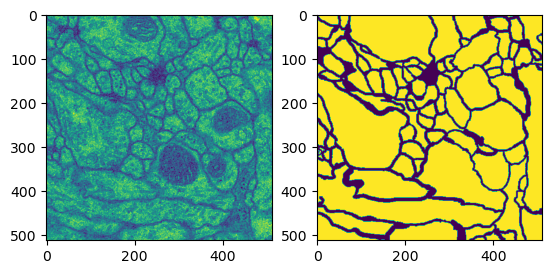

In [30]:
data = dataset_train.__getitem__(0)

input =  data['input']
label = data['label']

plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())

plt.imshow(input)

In [33]:
## 네트워크 학습하기 

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir= os.path.join(data_dir, 'train'), transform=transform)
loader_train =  DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = 8) # train dataset 불러오기

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

In [34]:
## 네트워크 생성하기 

net = UNet().to(device)

In [36]:
# 손실함수 정의하기

fn_loss = nn.BCEWithLogitsLoss().to(device)

In [38]:
# Optimizer 설정하기

optim = torch.optim.Adam(net.parameters(), lr=lr)

In [40]:
## 그 외 variable 설정 

num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_bathch_train = np.ceil(num_data_train / batch_size)
num_bathch_val = np.ceil(num_data_val / batch_size)

In [41]:
## 그 외 부수적인 함수 설정 

fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transposer(0,2,3,1) # tensor -> numpy로 변환
fn_denorm = lambda x , mean, std : (x * std) + mean # nor -> denorm
fn_class = lambda x : 1.0 * (x > 0.5) # 네트워크 아웃풋의 이미지를 바이너리 클래스로 분류

In [10]:
## Tensorboard 를 사용하기 위한 SummaryWriter 설정 

writer_train = SummaryWriter(log_dir =os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir =os.path.join(log_dir, 'val'))

NameError: name 'log_dir' is not defined